In [1]:
import mira
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mira.plots.base import map_plot
mira.utils.wide_view()
from IPython.display import Image
import os
DIR = '/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/'
RESULTS = 'data/code_ocean_results/'

rna_model = mira.topics.ExpressionTopicModel.load(os.path.join(DIR, 'shareseq_rna_model_rev1.pth'))
atac_model = mira.topics.AccessibilityTopicModel.load(os.path.join(DIR, 'shareseq_atac_model_rev1.pth'))
atac_model.encoder.calc_readdepth = False

for fig in ['fig5','fig2','fig3','fig4']:
    p = os.path.join(RESULTS, fig)
    if not os.path.exists(p):
        os.mkdir(p)

rna_data = sc.read_h5ad(os.path.join(DIR, 'checkpoint_rna_data.h5ad'))
atac_data = sc.read_h5ad(os.path.join(DIR, 'checkpoint_atac_data.h5ad'))

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [ ]:
rna_data.layers['counts'] = rna_data.X.copy()
sc.pp.normalize_total(rna_data, target_sum=1e4, layer = None)
rna_data.layers['normalized'] = rna_data.X.copy()
rna_data.X = rna_data.layers['counts']
rna_data.layers['smoothed'] = rna_data.obsp['connectivities'].dot(rna_data.layers['normalized'])/30 #knn smooth for visualization

with open(DIR + 'HF_cells.txt', 'r') as f:
    hf_cells = [x.strip() for x in f]

from collections import defaultdict

vaporwave_colormap = defaultdict(lambda : 'white')
vaporwave_colormap.update({
    'Upper Granular' : '#B874AE',
    'Upper Spinous' : '#927DB1',
    'Upper Basal' : '#476094',
    'Lower Granular' : '#DEC9DB',
    'Lower Spinous' : '#B2B4CF',
    'Lower Basal' : '#769AB5',
    'Outer Infandibulum' : '#83ABBF',
    'Infandibulum' : '#A2BBD8',
    'Inner Infandibulum' : '#E1D3E1',
    'Isthmus' : '#94BECC',
    'Inner Bulge' : '#EEEBED',
    'Upper Basal Cycling' : '#476094',
    'Upper Outer Bulge' : '#B9E2E3',
    'Lower Outer Bulge' : '#B9E2E3'
})

keratinocytes = rna_data[rna_data.obs.true_cell.isin(vaporwave_colormap.keys()) & (rna_data.obsm['joint_umap'][:,0] > 5)]

keratinocytes.obsm['joint_umap']*=np.array([[-1,1]])

fig, ax = plt.subplots(1,1,figsize=(5,8))
sc.pl.embedding(keratinocytes, basis='joint_umap', color = 'true_cell', palette=vaporwave_colormap, show = False, title = '',
               na_color='lightgrey', ax = ax, size = 15, frameon=False, legend_loc=None, legend_fontweight=530)
plt.savefig('sphinxdocs/source/_static/joint_representation.png')
#plt.savefig(os.path.join(RESULTS, 'fig5', '5a.png'), bbox_inches='tight')

Trying to set attribute `._uns` of view, copying.
Trying to set attribute `._uns` of view, copying.


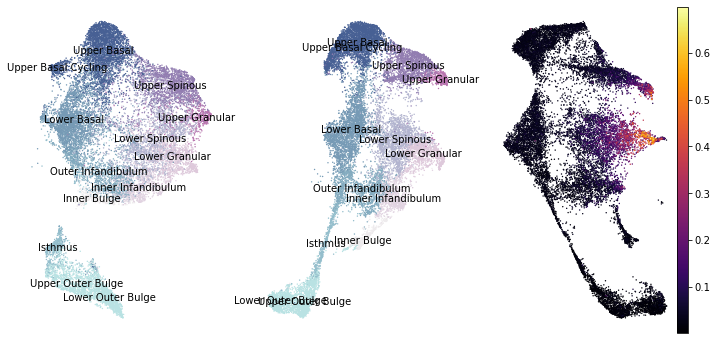

In [3]:
fig, ax = plt.subplots(1,3,figsize = (12,6))
sc.pl.embedding(keratinocytes[(keratinocytes.obsm['rna_only_umap'][:,0] > 4) & (keratinocytes.obsm['rna_only_umap'][:,1] > 0)], basis='rna_only_umap', color = 'true_cell', 
                palette=vaporwave_colormap, show = False, title = '',
               na_color='lightgrey', ax = ax[0], size = 8, frameon=False, legend_loc='on data', legend_fontweight=0)

sc.pl.embedding(keratinocytes[~((keratinocytes.obsm['atac_only_umap'][:,0] < 7) & (keratinocytes.obsm['atac_only_umap'][:,1] > 0))], basis='atac_only_umap', color = 'true_cell', 
                palette=vaporwave_colormap, show = False, title = '',
               na_color='lightgrey', ax = ax[1], size = 8, frameon=False, legend_loc='on data', legend_fontweight=0)

sc.pl.embedding(keratinocytes, basis='joint_umap', color = 'topic_13', show = False, title = '', color_map = 'inferno',
               na_color='lightgrey', ax = ax[2], size = 8, frameon=False, legend_loc = 'center bottom')
plt.savefig(os.path.join(RESULTS, 'fig5', '5cde.png'), bbox_inches='tight')

INFO:charset_normalizer:ascii passed initial chaos probing. Mean measured chaos is 0.000000 %
INFO:charset_normalizer:ascii should target any language(s) of ['Latin Based']
INFO:charset_normalizer:We detected language [('English', 1.0), ('Italian', 1.0), ('French', 1.0), ('Dutch', 1.0), ('Swedish', 1.0), ('Simple English', 1.0), ('Indonesian', 0.9848)] using ascii
INFO:charset_normalizer:ascii is most likely the one. Stopping the process.


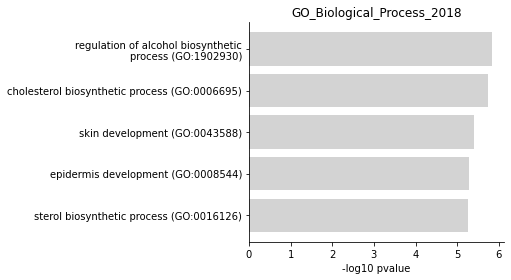

In [4]:
_id = rna_model.post_topic(13, 500)
rna_model.fetch_topic_enrichments(13, ontologies=['GO_Biological_Process_2018'])

rna_model.plot_enrichments(13, show_top = 5, color_by_adj=False,
                          aspect=1.8, show_genes = False)
plt.savefig(os.path.join(RESULTS, 'fig5', '5f.svg'), bbox_inches='tight')

In [5]:
epidermis = keratinocytes[keratinocytes.obs.true_cell.str.contains('Basal|Spinous|Granular')].copy()

sc.tl.diffmap(epidermis)
mira.time.normalize_diffmap(epidermis)

epidermis.obsm['X_diffmap'] = epidermis.obsm['X_diffmap'][:,:4]
sc.pp.neighbors(epidermis, use_rep='X_diffmap', key_added='X_diffmap')

mira.time.get_connected_components(epidermis)

mira.time.get_transport_map(epidermis, n_jobs=8,
                            start_cell=int(epidermis.obs.topic_0.argmax()))

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 7 diffusion map components.


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components
    Number of diffusion components (n_pcs) to use while calculating diffusion KNN graph was not set.
    This is new as of version 0.1.1. When calculating a diffusion KNN graph following 
        
        sc.tl.diffmap(adata)
        mira.time.normalize_diffmap(adata)

    You can check for the optimal number of diffusion components to use by:

        mira.pl.plot_eigengap(adata)

    The optimal number of components is the where the eigengap hueristic (y-axis)
    peaks. Or the minimum number of components that describes your cells' populations
    as per the UMAPS.

    You must then specify that number of components in the next step:

        sc.pp.neighbors(adata, n_pcs = HERE!, use_rep = "X_diffmap", key_added = "X_diffmap")
    
INFO:mira.pseudo

Calculating pseudotime:   0%|          | 0/65975 [00:00<?, ?it/s]

INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


INFO:mira.pseudotime.pseudotime:Found 3 terminal states from stationary distribution.
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'mira_connected_components' as categorical


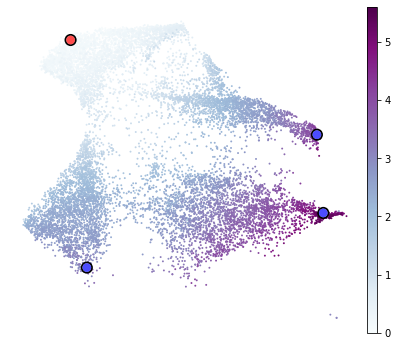

In [6]:
terminal_cells = mira.time.find_terminal_cells(epidermis, threshold=1e-3, 
                                               seed = 1776)

fig, ax = plt.subplots(1,1,figsize= (7,6))
sc.pl.embedding(epidermis, color = 'mira_pseudotime', color_map = 'BuPu', 
               basis = 'joint_umap', title = '', ax = ax, show = False, size = 15)
sc.pl.embedding(epidermis[epidermis.uns['start_cell']], frameon = False, na_color = 'Red',
               basis = 'joint_umap', title = '', ax = ax, show = False, size = 300, 
               add_outline=True, outline_color=('black','white'), outline_width=(0.2,0))
sc.pl.embedding(epidermis[terminal_cells], frameon = False, na_color = 'Blue',
               basis = 'joint_umap', title = '', ax = ax, show = False, size = 300, 
               add_outline=True, outline_color=('black','white'), outline_width=(0.2,0))
plt.savefig(os.path.join(RESULTS, 'fig5', '5g.png'), bbox_inches='tight')

In [7]:
mira.time.get_branch_probabilities(epidermis, 
                                  terminal_cells={
                                      'Upper Granular' : terminal_cells[0],
                                      'Lower Granular' : terminal_cells[2],
                                  })

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: Upper Granular_prob
INFO:mira.adata_interface.core:Added cols to obs: Lower Granular_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy


INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree


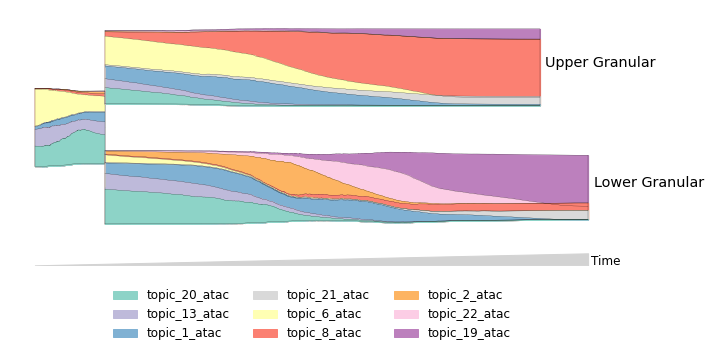

In [8]:
mira.time.get_tree_structure(epidermis, threshold = 3)
epidermis.obs['tree_states'] = np.where(epidermis.obs.tree_states.str.contains(',') & (epidermis.obs.mira_pseudotime > 1.2094), np.nan, epidermis.obs.tree_states)

stream_palette = [sns.color_palette('Set3')[i] for i in 
                  [0,2,4,-4,1,3,5,-5,-3]]
mira.pl.plot_stream(epidermis, window_size = 601, max_bar_height = 0.7, hide_feature_threshold=0,
        data = ['topic_{}_atac'.format(str(i)) for i in [20,13,1,21,6,8,2,22,19,]], 
        log_pseudotime=False, linewidth=0.2, legend_cols=3, palette = stream_palette, order = None)
plt.savefig(os.path.join(RESULTS, 'fig5', '5h.svg'), bbox_inches='tight')

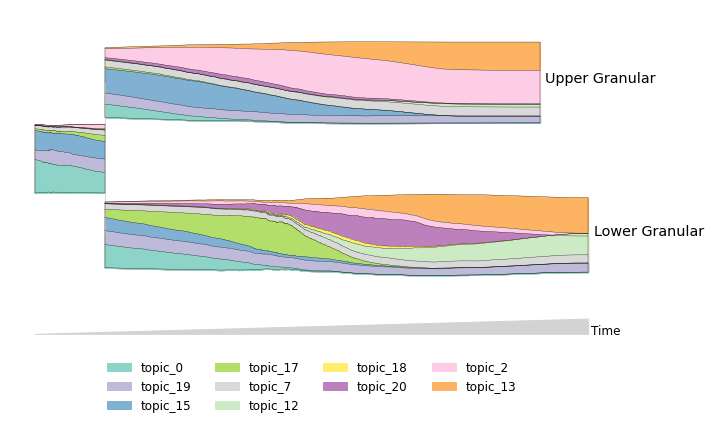

In [9]:
stream_palette = [sns.color_palette('Set3')[i] for i in 
                  [0,2,4,-4,1,3,5,-5,-3]]
mira.pl.plot_stream(epidermis, window_size = 601, max_bar_height = 0.7, hide_feature_threshold=0.03, figsize=(10,6),
        data = ['topic_{}'.format(str(i)) for i in [0, 15, 20, 2, 13, 12, 7, 19, 17, 18]], legend_cols=4,
        log_pseudotime=False, linewidth=0.3, palette = sns.color_palette('Set3')[0::2] + sns.color_palette('Set3')[1::2][::-1], order = 'ascending')
plt.savefig(os.path.join(RESULTS, 'suppfigs','5_epidermis_expression_topics.svg'), bbox_inches='tight')

Trying to set attribute `.obs` of view, copying.
INFO:mira.adata_interface.lite_nite:Added keys to obs: NITE_score, nonzero_counts
INFO:mira.adata_interface.lite_nite:Added keys to var: NITE_score, nonzero_counts
INFO:mira.adata_interface.core:Added layer: chromatin_differential


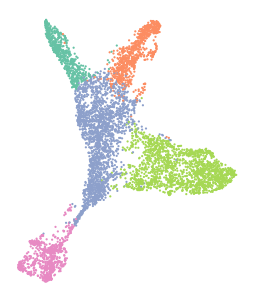

In [10]:
populations = ['Cortex', 'IRS', 'Inner Bulge', 'Inner Infandibulum',
       'Inner Matrix', 'Isthmus', 'Lower Basal', 'Lower Granular',
       'Lower Outer Bulge', 'Lower Spinous', 'Matrix', 'Medulla', 'ORS',
       'Outer Infandibulum', 'Outer Matrix', 'Upper Basal',
       'Upper Basal Cycling', 'Upper Granular', 'Upper Outer Bulge',
       'Upper Spinous']

rna_data = rna_data[rna_data.obs.true_cell.isin(populations)]
atac_data = atac_data[rna_data.obs_names]

mira.tl.get_NITE_score_cells(rna_data)
mira.tl.get_NITE_score_genes(rna_data)
mira.tl.get_chromatin_differential(rna_data)

hair_follicle = rna_data[hf_cells]

sc.pp.neighbors(hair_follicle, metric='manhattan', use_rep='X_joint_umap_features', n_neighbors = 30)
sc.tl.umap(hair_follicle, min_dist=0.1)

def rot_matrix(deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c, -s), (s, c)))

hair_follicle.obsm['vertical_umap'] = hair_follicle.obsm['X_umap'].dot(rot_matrix(35))*np.array([[-1,1]])
hair_follicle.obsm['horizontal_umap'] = hair_follicle.obsm['X_umap'].dot(rot_matrix(90+35))*np.array([[1,-1]])

hair_follicle_palette = dict(zip(
    hair_follicle.obs.true_cell.cat.categories,
    [sns.color_palette('Set2')[i] for i in [1, 4, 3, 2, 2, 0, 3, 4]]
))

fig, ax = plt.subplots(1,1,figsize=(4.3,5.3))
sc.pl.embedding(hair_follicle, basis='vertical_umap', color = 'true_cell', frameon=False,
          palette = hair_follicle_palette, ax = ax, legend_loc='center bottom', title = '', show = False)
plt.savefig(os.path.join(RESULTS, 'fig2', '2a.png'), bbox_inches='tight')

In [11]:
sc.tl.diffmap(hair_follicle)
mira.time.normalize_diffmap(hair_follicle)

hair_follicle 
sc.pp.neighbors(hair_follicle, n_neighbors = 30, use_rep = "X_diffmap", key_added = "X_diffmap", n_pcs = 5)
mira.time.get_connected_components(hair_follicle)

hair_follicle.obsm['X_diffmap'] = hair_follicle.obsm['X_diffmap'][:,:5]
mira.time.get_transport_map(hair_follicle, n_jobs = 5,
                            start_cell=int(atac_data[hair_follicle.obs_names].obs.topic_10.argmax()))

INFO:root:Added key to obsm: X_diffmap, normalized diffmap with 14 components.
INFO:root:Added key to uns: eigen_gap


Recommending 5 diffusion map components.


INFO:mira.pseudotime.pseudotime:Found 1 components of KNN graph.
INFO:mira.adata_interface.core:Added cols to obs: mira_connected_components
INFO:mira.pseudotime.pseudotime:Calculating inter-cell distances ...


Calculating pseudotime:   0%|          | 0/59575 [00:00<?, ?it/s]

INFO:mira.pseudotime.pseudotime:Calculating transport map ...
INFO:mira.adata_interface.pseudotime:Added key to obs: mira_pseudotime
INFO:mira.adata_interface.pseudotime:Added key to obsp: transport_map
INFO:mira.adata_interface.pseudotime:Added key to uns: start_cell


INFO:mira.pseudotime.pseudotime:Found 3 terminal states from stationary distribution.
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'mira_connected_components' as categorical


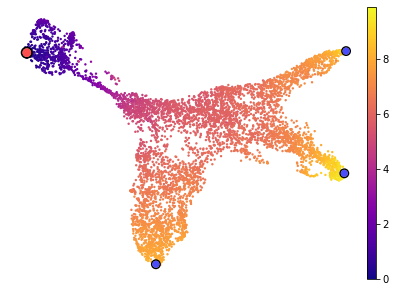

In [12]:
terminal_cells = mira.time.find_terminal_cells(hair_follicle, seed = 1775)

fig, ax = plt.subplots(1,1,figsize=(7,5))
sc.pl.embedding(hair_follicle, basis='horizontal_umap', size = 23,
                color = 'mira_pseudotime', color_map='plasma', ax = ax, show = False)
sc.pl.embedding(hair_follicle[terminal_cells], basis='horizontal_umap', 
                na_color = 'blue', add_outline=True, outline_color=('black','white'), outline_width=(0.2, 0), size = 200,
                ax = ax, show = False)
sc.pl.embedding(hair_follicle[hair_follicle.uns['start_cell']], basis='horizontal_umap', 
                na_color = 'red', add_outline=True, outline_color=('black','white'), outline_width=(0.2, 0), size = 300,
                ax = ax, frameon=False, show = False)
plt.savefig(os.path.join(RESULTS, 'fig2', '2b_top.png'), bbox_inches='tight')

INFO:mira.pseudotime.pseudotime:Simulating random walks ...
INFO:mira.adata_interface.pseudotime:Added key to obsm: branch_probs
INFO:mira.adata_interface.pseudotime:Added key to uns: lineage_names
INFO:mira.adata_interface.core:Added cols to obs: Medulla_prob
INFO:mira.adata_interface.core:Added cols to obs: Cortex_prob
INFO:mira.adata_interface.core:Added cols to obs: IRS_prob
INFO:mira.adata_interface.core:Added cols to obs: differentiation_entropy
/Users/alynch/projects/multiomics/mira/mira/mira/plots/base.py:57: RuntimeWarning: All-NaN slice encountered
  np.nanmin(c) if vmin is None else vmin,
/Users/alynch/projects/multiomics/mira/mira/mira/plots/base.py:58: RuntimeWarning: All-NaN slice encountered
  np.nanmax(c) if vmax is None else vmax),


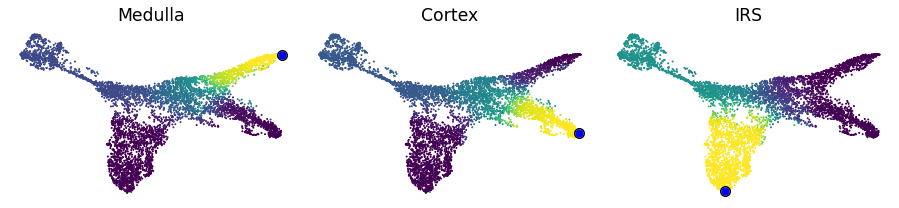

In [13]:
mira.time.get_branch_probabilities(hair_follicle, terminal_cells=dict(zip(('Medulla','Cortex','IRS'), [terminal_cells[i] for i in [1,0,2]])))

def plot_lineage_prob(ax, lineage, terminal_state):
    
    mira.plots.base.plot_umap(hair_follicle.obsm['horizontal_umap'], hair_follicle.obs_vector(lineage + '_prob'), 
                              palette = 'viridis', add_legend=False, ax = ax, size = 1)
    mira.plots.base.plot_umap(hair_follicle[terminal_state].obsm['horizontal_umap'], np.array([np.nan]), 
                              palette = 'viridis', na_color='blue', size = 50, add_legend=False, ax = ax,
                             add_outline=True, outline_color = 'black', outline_width=(0,1))
    ax.set_title(lineage, fontsize = 'xx-large')

mira.plots.base.map_plot(
    plot_lineage_prob, list(zip(hair_follicle.uns['lineage_names'], hair_follicle.uns['terminal_cells'])),
    height = 3, aspect=7/5
)
plt.savefig(os.path.join(RESULTS, 'fig2', '2b_middle.png'), bbox_inches='tight')

INFO:mira.adata_interface.pseudotime:Added key to obs: tree_states
INFO:mira.adata_interface.pseudotime:Added key to uns: tree_state_names
INFO:mira.adata_interface.pseudotime:Added key to uns: connectivities_tree


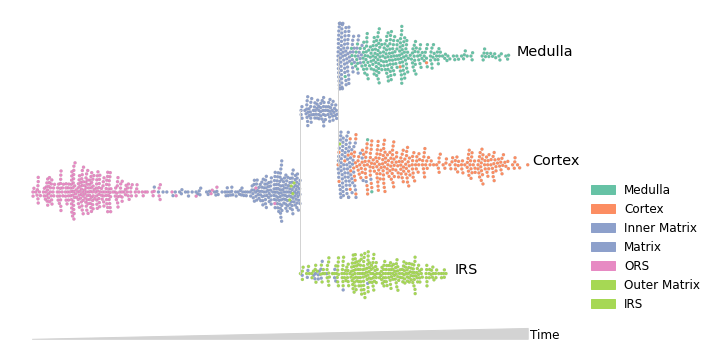

In [14]:
mira.time.get_tree_structure(hair_follicle, threshold=1.5)

c = sns.color_palette('Set2')
hair_follicle.obs.true_cell = hair_follicle.obs.true_cell.astype(str)
mira.pl.plot_stream(hair_follicle[hair_follicle.obs.true_cell.isin(['Cortex','IRS','Inner Matrix','Matrix', 'Medulla', 'ORS', 'Outer Matrix'])], 
                    data= 'true_cell', style='swarm', log_pseudotime=False, size=10,
                   palette=[c[0],c[1],c[2],c[2],c[3],c[4],c[4]], hue_order=['Medulla','Cortex','Inner Matrix','Matrix','ORS','Outer Matrix','IRS'],
                    max_swarm_density=100, linewidth = 0.1, linecolor = 'grey')
plt.savefig(os.path.join(RESULTS, 'fig2', '2b_bottom.png'), bbox_inches='tight')

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


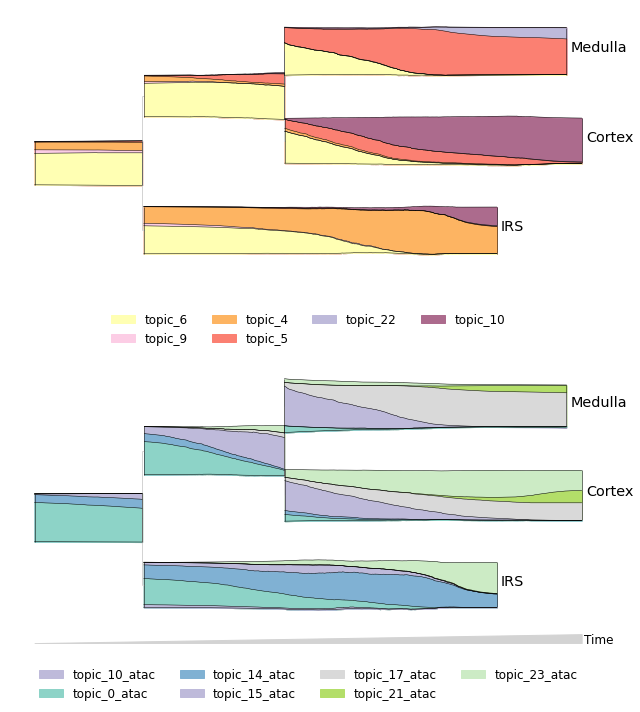

In [15]:
hair_follicle.obs['adj_pseudotime'] = np.log(hair_follicle.obs.mira_pseudotime - 4.3)
rna_topic_color_palette = [
    sns.color_palette('Set3')[i] for i in [1,7, 5, 3, 2]
] + [[172/255, 107/255, 141/255]]

atac_topic_color_palette = [
    sns.color_palette('Set3')[i] for i in [2, 0, 4, 2, -4, -6, -2]
]

stream_kwargs = dict(hide_feature_threshold=0.03, window_size=301, linewidth=0.5,
                     pseudotime_key = 'adj_pseudotime',log_pseudotime=False, max_bar_height = 0.7)

fig, ax = plt.subplots(2,1,figsize=(9,10))
mira.pl.plot_stream(hair_follicle[hair_follicle.obs.mira_pseudotime > 5], order = None, ax = ax[0],
                    data = ['topic_6','topic_9','topic_4','topic_5','topic_22','topic_10'],                      
                   palette=rna_topic_color_palette, legend_cols=4, **stream_kwargs, pseudotime_triangle=False)

mira.pl.plot_stream(hair_follicle[hair_follicle.obs.mira_pseudotime > 5], order = None, ax = ax[1],
                    data = ['topic_10_atac','topic_0_atac','topic_14_atac','topic_15_atac','topic_17_atac','topic_21_atac','topic_23_atac'],
                   palette=atac_topic_color_palette, legend_cols=4, **stream_kwargs)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS, 'fig2', '2c.svg'), bbox_inches='tight')

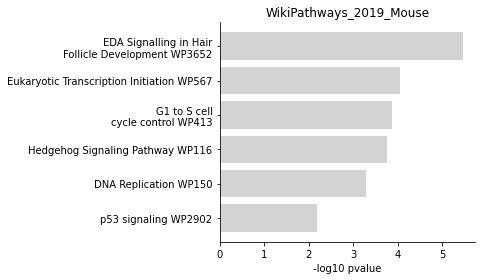

In [16]:
import logging
logging.getLogger().setLevel(logging.WARN)
rna_model.post_topic(6, 500)
rna_model.fetch_topic_enrichments(6, ontologies=['WikiPathways_2019_Mouse'])

rna_model.plot_enrichments(6, show_genes=False, color_by_adj=False, show_top = 6, aspect=1.7)
logging.getLogger().setLevel(logging.INFO)
plt.savefig(os.path.join(RESULTS, 'fig2', '2d_left.svg'), bbox_inches='tight')

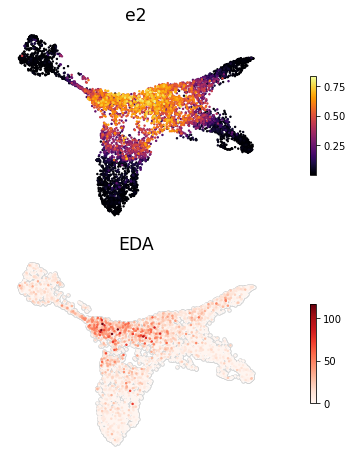

In [17]:
fig, ax = plt.subplots(2,1,figsize=(5,6.5))

mira.plots.base.plot_umap(hair_follicle.obsm['horizontal_umap'], 
                          hair_follicle.obs_vector('topic_6'),
                         add_outline = False, ax = ax[0], palette = "inferno",
                         outline_width=(0, 5))
ax[0].set_title('e2', fontsize='xx-large')

mira.plots.base.plot_umap(hair_follicle.obsm['horizontal_umap'], 
                          hair_follicle.obs_vector('EDA', layer='normalized'),
                         add_outline = True, ax = ax[1], palette = "Reds",
                         outline_width=(0, 5))
ax[1].set_title('EDA', fontsize='xx-large')
ax[0].set_title('e2', fontsize='xx-large')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS, 'fig2', '2c_right.png'), bbox_inches='tight')

In [18]:
atac_model.get_enriched_TFs(atac_data, topic_num=17, top_quantile=0.1)
atac_model.get_enriched_TFs(atac_data, topic_num=23, top_quantile=0.1)

Finding enrichments:   0%|          | 0/555 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/555 [00:00<?, ?it/s]

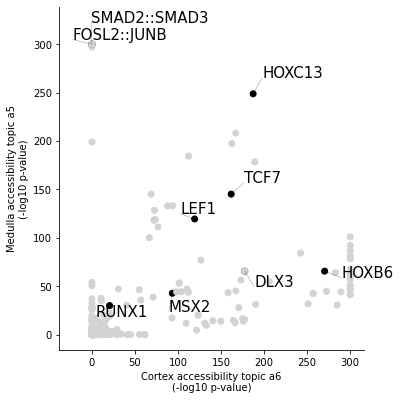

In [19]:
label_factors = ['LEF1','HOXC13','HOXB6','MSX2','DLX3','SMAD2::SMAD3','FOSL2::JUNB','TCF7','RUNX1']
ax = atac_model.plot_compare_topic_enrichments(23, 17, 
        label_factors = label_factors, hue = {factor : 1. for factor in label_factors},
        fontsize=15, label_closeness=6, figsize=(5.5,5.5), na_color='lightgrey',
        palette = 'Greys_r', show_legend=False,
     )
ax.set(ylabel = 'Medulla accessibility topic a5\n(-log10 p-value)',
      xlabel = 'Cortex accessibility topic a6\n(-log10 p-value)')
plt.savefig(os.path.join(RESULTS, 'fig2', '2e.svg'), bbox_inches='tight')

In [ ]:
for layer in ['chromatin_differential','LITE_prediction','NITE_prediction', 'normalized','smoothed']:
    hair_follicle.layers[layer] = rna_data[hair_follicle.obs_names, hair_follicle.var_names].layers[layer]

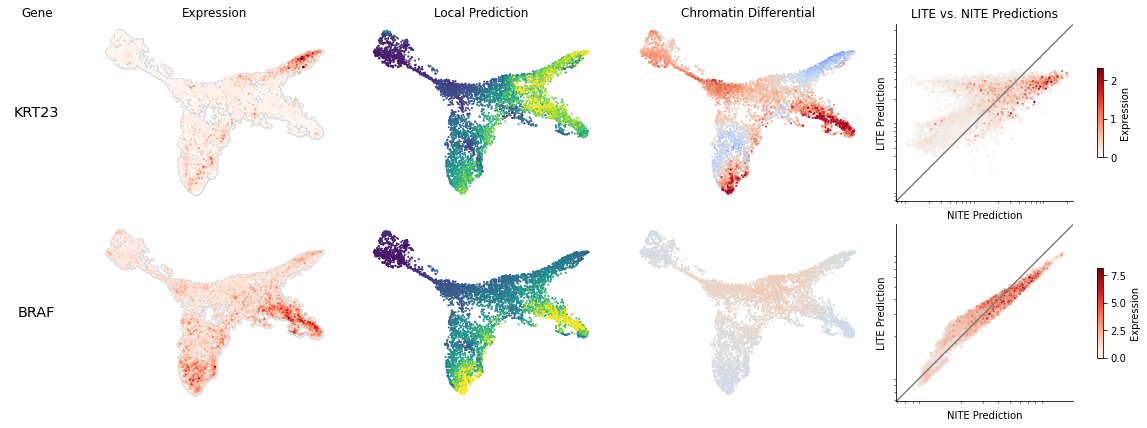

In [38]:
mira.pl.plot_chromatin_differential(hair_follicle, genes = ['KRT23','BRAF'], counts_layer='smoothed', aspect=1.26,
                                   trim_lite_prediction=2, basis = 'horizontal_umap', add_legend=False)
plt.savefig(os.path.join(RESULTS, 'fig3', '3abef_.png'))

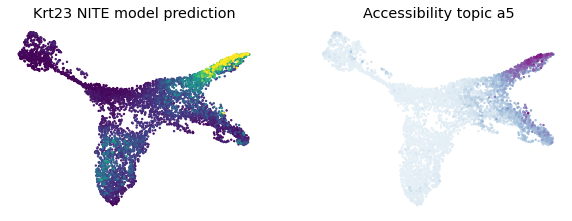

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))
mira.plots.base.plot_umap(hair_follicle.obsm['horizontal_umap'], hair_follicle.obs_vector('KRT23', layer='NITE_prediction'),
                         ax= ax[0], add_legend=False, vmax=0.0012)
ax[0].set_title('KRT23 NITE Prediction', fontsize='xx-large')
mira.plots.base.plot_umap(hair_follicle.obsm['horizontal_umap'], hair_follicle.obs_vector('topic_17_atac'),
                         ax= ax[1], add_legend=False, palette = 'BuPu', vmin = -0.1, vmax = 1.0)

ax[0].set_title('Krt23 NITE model prediction', fontsize='x-large')
ax[1].set_title('Accessibility topic a5', fontsize='x-large')
plt.savefig(os.path.join(RESULTS, 'fig3', '3c.png'), bbox_inches='tight')

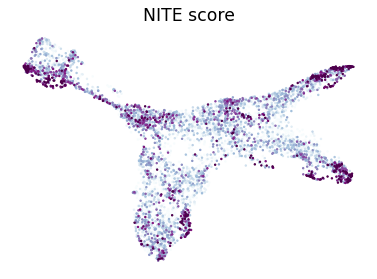

In [22]:
ax = mira.plots.base.plot_umap(hair_follicle.obsm['horizontal_umap'], hair_follicle.obs_vector('NITE_score'),
                         add_legend=False, palette = 'BuPu', vmin = 7, vmax = 30, figsize=(6.5,4.5), size = 2)
ax.set_title('NITE score', fontsize='xx-large')
plt.savefig(os.path.join(RESULTS, 'fig4', '4a.png'), bbox_inches='tight')

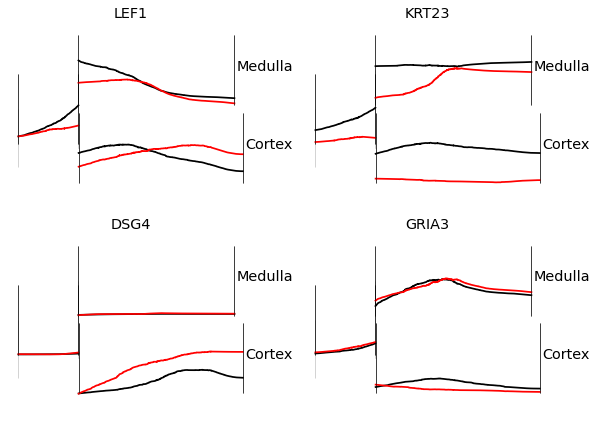

In [23]:
compare_stream_kwargs = dict(style = 'line', show_legend=False,
                             max_bar_height=0.9, scale_features=True, clip=3, 
                             order=None, palette=['red','black'],
                             figsize=(4,3), layers = ['smoothed','LITE_prediction'], 
                             window_size = 351, log_pseudotime = False, 
                             pseudotime_key = 'adj_pseudotime', pseudotime_triangle = False)

def make_plot(ax, gene):
    mira.pl.plot_stream(hair_follicle[(hair_follicle.obs.mira_pseudotime>5.5) & (hair_follicle.obs.tree_states.str.contains('Cortex|Medulla'))], ax = ax,
                    title = gene, data = [gene, gene], **compare_stream_kwargs)

map_plot(make_plot, [[gene] for gene in ['LEF1','KRT23','DSG4','GRIA3']], 
         plots_per_row=2,  height = 3, aspect = 1.4)
plt.savefig(os.path.join(RESULTS, 'fig4', '4c_right.svg'), bbox_inches='tight')

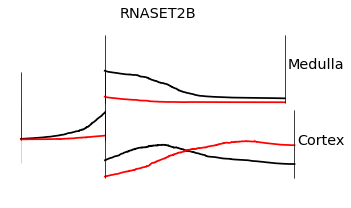

In [24]:
def make_plot(ax, gene):
    mira.pl.plot_stream(hair_follicle[(hair_follicle.obs.mira_pseudotime>5.4) & (hair_follicle.obs.tree_states.str.contains('Cortex|Medulla'))], ax = ax,
                    title = gene, data = [gene, gene], **compare_stream_kwargs)
    
fig, ax = plt.subplots(1,1,figsize=(5,3))
make_plot(ax, 'RNASET2B')
plt.savefig(os.path.join(RESULTS, 'fig4','4b.svg'), bbox_inches='tight')

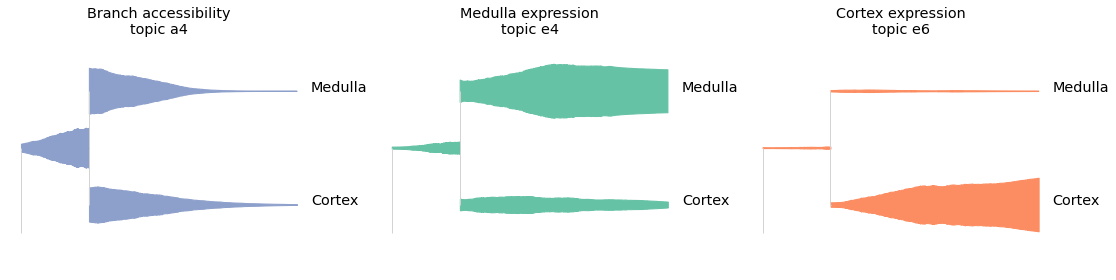

In [25]:
hair_follicle.obs['adj_pseudotime'] = np.log(hair_follicle.obs.mira_pseudotime + 1)
map_plot(lambda ax, x, c, t : mira.pl.plot_stream(hair_follicle[(~hair_follicle.obs.tree_states.str.contains('IRS')) & (hair_follicle.obs.mira_pseudotime < 9)],log_pseudotime=False,
                       data = x, color = c, ax = ax, pseudotime_triangle=False, title = t, pseudotime_key = 'adj_pseudotime'),
         [('topic_15_atac', sns.color_palette('Set2')[2], 'Branch accessibility\ntopic a4'), 
          ('topic_5', sns.color_palette('Set2')[0],'Medulla expression\ntopic e4'),
          ('topic_10', sns.color_palette('Set2')[1], 'Cortex expression\ntopic e6')], height =4, aspect = 1.3)
plt.savefig(os.path.join(RESULTS, 'fig4','4f.svg'), bbox_inches='tight')

Trying to set attribute `.obs` of view, copying.
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'true_cell' as categorical
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tree_states' as categorical
/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter i

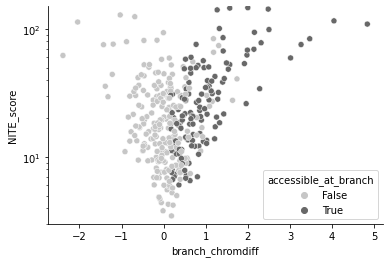

In [26]:
with open(DIR + 'rp_model_genes.txt','r') as f: 
    rp_genes = [x.strip() for x in f] + ['JAG1']
hair_follicle = hair_follicle[:, rp_genes ]

hair_follicle.obs['branch_cell'] = np.isin(np.arange(len(hair_follicle)), atac_data[hair_follicle.obs_names].obs.topic_15.argsort().tail(150).values)
hair_follicle.var['branch_chromdiff'] = np.nanmean(hair_follicle[hair_follicle.obs.branch_cell,:].layers['chromatin_differential'].toarray(), axis = 0)

sc.tl.rank_genes_groups(hair_follicle, groupby='tree_states', groups=['Cortex'], reference='Medulla', method='wilcoxon', layer='normalized')
lineage_DE = sc.get.rank_genes_groups_df(hair_follicle, group='Cortex').set_index('names')
lineage_DE_genes = lineage_DE[(lineage_DE.pvals_adj <= 0.1) & (np.abs(lineage_DE.logfoldchanges) >= 1)].index.values

fig4_genes = np.intersect1d(lineage_DE_genes, atac_data.uns['distance_to_TSS_genes'])

hair_follicle.obs['hairshaft'] = hair_follicle.obs.tree_states.map({'Cortex' : 'Cortex', 'Medulla': 'Medulla', 'Cortex, Medulla' : 'pre-HS', 'Cortex, IRS, Medulla' : 'pre-HS', 'IRS' : 'IRS'})

sc.tl.rank_genes_groups(hair_follicle, groupby='hairshaft', groups=['Cortex','Medulla'], reference='pre-HS', method='wilcoxon')
medulla_hairshaft_DE = sc.get.rank_genes_groups_df(hair_follicle, group='Medulla')
cortex_hairshaft_DE = sc.get.rank_genes_groups_df(hair_follicle, group='Cortex')

not_expressed_at_branch_genes = np.union1d(
    medulla_hairshaft_DE[(medulla_hairshaft_DE.logfoldchanges > 1) & (medulla_hairshaft_DE.pvals_adj < 0.1)].names.values,
    cortex_hairshaft_DE[(cortex_hairshaft_DE.pvals_adj < 0.1) & (cortex_hairshaft_DE.logfoldchanges > 1)].names.values)

hair_follicle.var['isd_genes'] = hair_follicle.var_names.isin(fig4_genes)
hair_follicle.var['expressed_at_branch'] = ~hair_follicle.var_names.isin(not_expressed_at_branch_genes) & hair_follicle.var.isd_genes
hair_follicle.var['NITE_score'] = rna_data.var['NITE_score']
hair_follicle.var['accessible_at_branch'] = (hair_follicle.var.branch_chromdiff > 0.15) & (hair_follicle.var.NITE_score > 5) & hair_follicle.var.isd_genes & ~hair_follicle.var.expressed_at_branch
hair_follicle.var['accessible_after_branch'] = ~(hair_follicle.var.expressed_at_branch | hair_follicle.var.accessible_at_branch) & hair_follicle.var.isd_genes
hair_follicle.var['cortex_DE'] = ((lineage_DE.logfoldchanges.values > 1) & (lineage_DE.pvals_adj < 0.1)) & (lineage_DE.logfoldchanges > 1)
hair_follicle.var['medulla_DE'] = ((lineage_DE.logfoldchanges.values < 1) & (lineage_DE.pvals_adj < 0.1)) & (lineage_DE.logfoldchanges < -1)

ax = sns.scatterplot(
    data=hair_follicle.var.loc[lineage_DE_genes],
    x = 'branch_chromdiff',
    y = 'NITE_score',
    hue = 'accessible_at_branch',
    palette='Greys'
)
ax.set(yscale = 'log')
ax.set(ylim = (3, 150))
sns.despine()

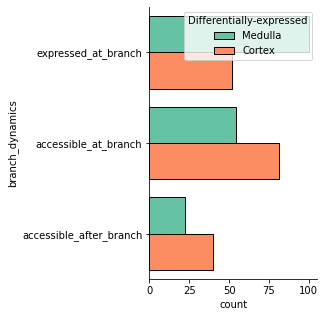

In [27]:
categories = np.array(['expressed_at_branch','accessible_at_branch','accessible_after_branch'])
hair_follicle.var['branch_dynamics'] = categories[hair_follicle.var[categories].values.argmax(-1)]

hair_follicle.var['Differentially-expressed'] = np.where(hair_follicle.var.cortex_DE, 'Cortex','Medulla')

fig, ax = plt.subplots(1,1,figsize=(3,5))
sns.countplot(data = hair_follicle.var[hair_follicle.var.isd_genes],
             y = 'branch_dynamics', hue = 'Differentially-expressed', order = categories,
             palette = 'Set2', saturation=1., edgecolor = 'black', ax = ax)
sns.despine()
plt.savefig(os.path.join(RESULTS, 'fig4', '4c_left.svg'), bbox_inches='tight')

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


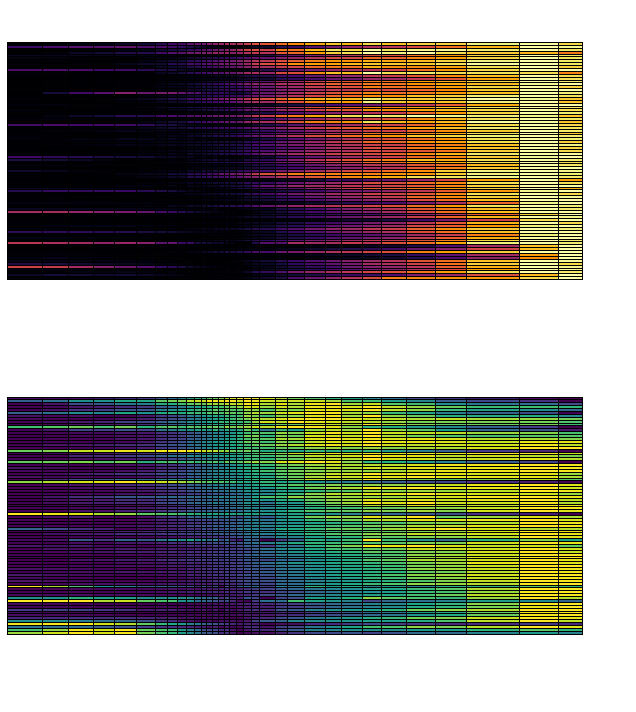

In [28]:
cortex_primed = hair_follicle.var_names[hair_follicle.var.isd_genes & hair_follicle.var.accessible_at_branch & hair_follicle.var.cortex_DE].values
medulla_primed = hair_follicle.var_names[hair_follicle.var.isd_genes & hair_follicle.var.accessible_at_branch & hair_follicle.var.medulla_DE].values

order = cortex_primed
plot_data = hair_follicle[hair_follicle.obs.tree_states.str.contains('Cortex') \
                                          & (hair_follicle.obs.mira_pseudotime > 4.5) & (hair_follicle.obs.mira_pseudotime < 9)]
corrs = [
    np.corrcoef(np.log(plot_data.obs_vector('topic_15_atac')), np.log(plot_data.obs_vector(gene, layer = 'LITE_prediction')))[0,1]
    for gene in order
]

order = order[np.argsort(corrs)[::-1]]
plot_data.layers['LITE_prediction'] = np.log(plot_data.layers['LITE_prediction'].toarray())

fig, ax = plt.subplots(2,1,figsize=(10,10))

mira.pl.plot_stream(plot_data, ax=ax[0],
                data = list(order) + ['topic_10'], layers = ['NITE_prediction']*len(order) + [None], palette='inferno', linecolor = None, 
                   window_size=71, style='heatmap', order = None, pseudotime_triangle=False, tree_structure=False)
ax[0].set(yticks = [])

mira.pl.plot_stream(plot_data, ax=ax[1],
                   data = ['topic_15_atac'] + list(order), layers = [None] + ['LITE_prediction']*len(order), palette='viridis', scaffold_linecolor= None,
                   window_size=71, style='heatmap', order = None, pseudotime_triangle=False, tree_structure=False)
ax[1].set(yticks = [])
plt.savefig(os.path.join(RESULTS, 'fig4', '4d_left.svg'), bbox_inches='tight')

INFO:mira.tools.tf_targeting:Testing with 81 query genes and 4534 background genes, against 555 factors


Testing factors:   0%|          | 0/555 [00:00<?, ?it/s]

INFO:mira.tools.tf_targeting:Testing with 54 query genes and 4534 background genes, against 555 factors


Testing factors:   0%|          | 0/555 [00:00<?, ?it/s]

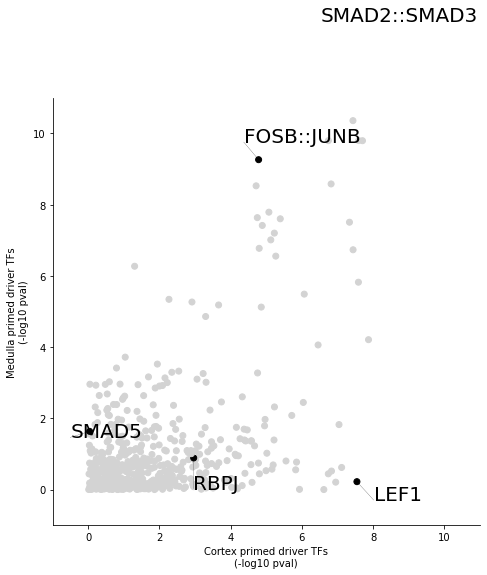

In [29]:
label = ['LEF1','RBPJ','SMAD2::SMAD3','SMAD5','FOSB::JUNB']
ax = mira.pl.compare_driver_TFs_plot(hair_follicle, color = 'lightgrey', fontsize=20,
            geneset1=cortex_primed, geneset2=medulla_primed,
            label_factors=label, palette = 'Greys_r', ax = None, figsize=(7,7),
            hue = {factor : 1. for factor in label}, show_legend=False, label_closeness=7,
            background = np.setdiff1d(rp_genes, lineage_DE_genes),
            axlabels = ('Cortex primed driver TFs\n(-log10 pval)', 'Medulla primed driver TFs\n(-log10 pval)')
)
plt.axis('square')
ax.set(ylim = (-1,11),xlim = (-1,11))
plt.savefig(os.path.join(RESULTS, 'fig4', '4e.svg'))

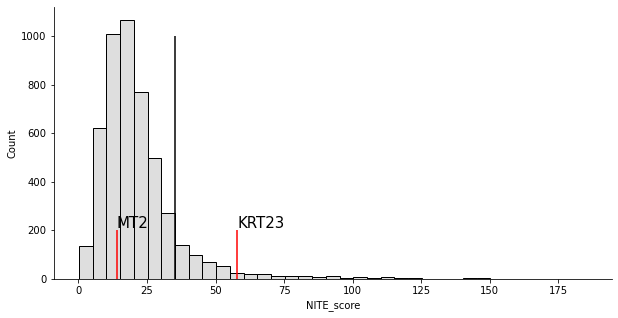

In [35]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.histplot(data = rna_data.var, x = 'NITE_score', color='lightgrey', binwidth=5)
ax.vlines(rna_data.var.loc['KRT23'].NITE_score, ymin = 0, ymax = 200, color = 'red')
ax.text(x = rna_data.var.loc['KRT23'].NITE_score, y = 210, s = 'KRT23', fontsize=15)
ax.vlines(rna_data.var.loc['MT2'].NITE_score, ymin = 0, ymax = 200, color = 'red')
ax.text(x = rna_data.var.loc['MT2'].NITE_score, y = 210, s = 'MT2', fontsize=15)
ax.vlines(rna_data.var.NITE_score.dropna().sort_values().iloc[-500], ymin = 0, ymax = 1000, color = 'black')
sns.despine()

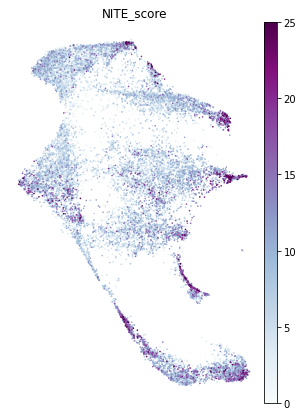

In [36]:
fig, ax = plt.subplots(1,1,figsize=(5,7))
sc.pl.embedding(keratinocytes, color = 'NITE_score', basis = 'joint_umap', ax =ax, color_map='BuPu', vmin = 0, vmax = 25, frameon=False,
               size = 10)

In [37]:
from scipy.stats import pearsonr, spearmanr

In [38]:
rows = rna_model.topic_cols
cols = list(map(lambda x : x + '_atac', atac_model.topic_cols))
corrs = []

for rna_topic in rna_model.topic_cols:
    corrs.append([
        pearsonr(hair_follicle.obs_vector(rna_topic), hair_follicle.obs_vector(atac_topic))[0]
        for atac_topic in cols
    ])

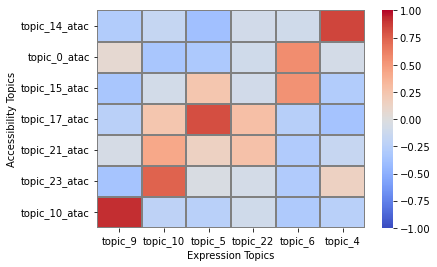

In [39]:
ax = sns.heatmap(
    pd.DataFrame(corrs, columns= cols, index = rows)\
        .loc[['topic_9','topic_10','topic_5','topic_22','topic_6','topic_4'], ['topic_14_atac','topic_0_atac','topic_15_atac','topic_17_atac','topic_21_atac','topic_23_atac','topic_10_atac']].T,
    cmap = 'coolwarm', edgecolor = 'black', linewidth = 0.01, linecolor = 'grey', vmin = -1, vmax = 1,
)
ax.set(xlabel = 'Expression Topics', ylabel = 'Accessibility Topics')
plt.savefig(os.path.join(RESULTS,'suppfigs','hair_follicle_cross_topic_comparison_coolwarm.svg'), bbox_inches='tight')

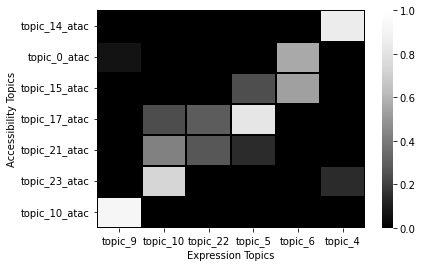

In [40]:
ax = sns.heatmap(
    pd.DataFrame(corrs, columns= cols, index = rows)\
        .loc[['topic_9','topic_10','topic_22','topic_5','topic_6','topic_4'], ['topic_14_atac','topic_0_atac','topic_15_atac','topic_17_atac','topic_21_atac','topic_23_atac','topic_10_atac']].T,
    cmap = 'Greys_r', edgecolor = 'black', linewidth = 0.01, linecolor = 'black', vmin = 0, vmax = 1,
)
ax.set(xlabel = 'Expression Topics', ylabel = 'Accessibility Topics')
plt.savefig(os.path.join(RESULTS,'suppfigs','hair_follicle_cross_topic_comparison_black.svg'), bbox_inches='tight')

In [41]:
import anndata
import scanpy as sc
import pandas as pd
import mira
import os
import seaborn as sns
DIR = '/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/'
RESULTS = 'data/code_ocean_results/'
c = sns.color_palette('Set2')

hair_follicle = anndata.read_h5ad('data/shareseq/figstuff/hair_follicle.h5ad')
atac_data = anndata.read_h5ad('data/shareseq/figstuff/hair_follicle.h5ad')
rna_model = mira.topics.ExpressionTopicModel.load(os.path.join(DIR, 'shareseq_rna_model_rev1.pth'))
atac_model = mira.topics.AccessibilityTopicModel.load(os.path.join(DIR, 'shareseq_atac_model_rev1.pth'))
atac_model.encoder.calc_readdepth = False

In [42]:
from pygenometracks.tracks import BedGraphTrack

import numpy as np
from scipy import sparse
from lisa.core.genome_tools import Region
import warnings
import matplotlib.patches as patches
import tqdm
from mira.plots.rp_plots import _plot_rp_models
from pygenometracks.tracks import BedTrack

def _residual_transform(X, pi_j_hat, n_i):
    
    assert(isinstance(X, np.ndarray))
    assert(isinstance(pi_j_hat, np.ndarray))
    assert(isinstance(n_i, np.ndarray))
    pi_j_hat = np.squeeze(pi_j_hat)[np.newaxis, :]
    n_i = np.squeeze(n_i)[:, np.newaxis]

    mu_ij_hat = n_i * pi_j_hat

    count_dif = n_i - X
    expected_count_dif = n_i - mu_ij_hat

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        r_ij = np.multiply(
            np.sign(X - mu_ij_hat), 
            np.sqrt(
            np.where(X > 0, 2 * np.multiply(X, np.log(X / mu_ij_hat)), 0) + \
            2 * np.multiply(count_dif, np.log(count_dif / expected_count_dif))
            )
        )

    return np.clip(np.nan_to_num(r_ij), -10, 10)

def _get_pi(X):
    return np.array(X.sum(0)).reshape(-1)/X.sum()

def _get_n(X):
    return np.array(X.sum(-1)).reshape(-1)


def _make_regpanel(ax,*, accessibility, chrom, start, end, peaks, time, height = 1):

    accessibility.data = np.ones_like(accessibility.data)
    n_i = _get_n(accessibility)
    p_i = _get_pi(accessibility)

    interval = Region(chrom, start, end)

    overlapped_peaks = np.array([
        Region(*peak).overlaps(interval)
        for peak in peaks
    ])
    
    order = time.argsort()

    X = accessibility[:, overlapped_peaks].toarray()[order, :]

    residuals = _residual_transform(X, p_i[overlapped_peaks], n_i)

    ax.set(xlim = (start, end), ylim = (0, len(residuals)))
    t_ = iter(tqdm.notebook.trange((residuals > 0).sum(), desc = 'Plotting fragments'))

    for alpha, position in zip(residuals.T, peaks[overlapped_peaks]):
        
        start, end = (int(position[1]), int(position[2]))
        min_, max_ = alpha.min(), alpha.max()
        transparency = (alpha - min_)/(max_ - min_)
        
        for j, a in enumerate(alpha):
            if a > 0:
                ax.add_patch(
                    patches.Rectangle((start, j), (end - start), height, color = 'black', alpha = transparency[j])
                )
                next(t_)

    ax.invert_yaxis()

tss = pd.DataFrame(atac_data.uns['TSS_metadata']).set_index('gene')

In [29]:
litemodel = mira.rp_model.LITE_Model.load_dir(expr_model=rna_model, accessibility_model=atac_model,
                                              prefix='/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/rp_models/')

In [30]:
tss['value'] = 0
tss.reset_index()[['chromosome','txStart','txEnd','gene','value','strand']].to_csv('data/mm10_tss.bed', index = None, header = None, sep = '\t')

In [31]:
!sort -k1,1 -k2,2n data/mm10_tss.bed > tmp && mv tmp data/mm10_tss.bed

In [32]:
hf_palette = [c[0],c[1],c[2],c[2],c[3],c[4],c[4]]
hf_hue_order=['Medulla','Cortex','Inner Matrix','Matrix','ORS','Outer Matrix','IRS']

In [33]:
def make_fragment_plot(gene, lineage, upstream_margin, downstream_margin, ylim, enforce_max = (1.25, 0.0005)):
    
    chrom, start, end = tss.loc[gene][['chromosome','txStart','txEnd']].values

    cells = hair_follicle[hair_follicle.obs.tree_states.str.contains(lineage) & (hair_follicle.obs.mira_pseudotime < 8.5)].obs_names
    start = start - upstream_margin
    end = end + downstream_margin

    fig5 = plt.figure(constrained_layout=False, figsize=(15,11))
    widths = [4, 0.5, 0.25]
    heights = [1, 1, 4]
    spec5 = fig5.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
                        height_ratios=heights)

    fragments_ax = fig5.add_subplot(spec5[-1,0])
    for spine in ['left','right','top','bottom']:
        fragments_ax.spines[spine].set_visible(False)
    fragments_ax.set(xticks = [], yticks = [])
    _make_regpanel(fragments_ax, accessibility = atac_data[cells].X, chrom = chrom, time = hair_follicle[cells].obs.mira_pseudotime.values,
                   start = start, end = end, peaks = atac_data.var[['chr','start','end']].values, height = 3)


    rp_axes = fig5.add_subplot(spec5[-2,0])
    rp_axes.axis('off')
    _plot_rp_models(rp_axes, bin_size = 200,
            interval_chrom = chrom, interval_start = start, interval_end = end, rp_models = litemodel.subset([gene]), 
            gene_id = atac_data.uns['TSS_metadata']['gene'], 
            chrom = atac_data.uns['TSS_metadata']['chromosome'], 
            start = atac_data.uns['TSS_metadata']['txStart'],
            end = atac_data.uns['TSS_metadata']['txEnd'], 
            strand = atac_data.uns['TSS_metadata']['strand'])
    rp_axes.set(xlim = (start, end))

    track = BedTrack(dict(file = 'data/mm10_tss.bed', section_name = 'Track', color = 'black'))
    track_ax = fig5.add_subplot(spec5[0,0])
    track_ax.set(xlim = (start, end))
    track.plot(track_ax, chrom, start, end)
    track_ax.axis('off')

    streamax = fig5.add_subplot(spec5[-1,1])
    rna_cells = hair_follicle[cells]
    rna_cells.obs['ordered_cells'] = len(rna_cells) - rna_cells.obs.mira_pseudotime.argsort().argsort()
    
    
    mira.pl.plot_stream(rna_cells,data = [gene], layers = ['smoothed'],
                        order=None, style = 'line', pseudotime_triangle=False, clip = 7, color='red', palette=['red'], max_bar_height = 0.99,
                   window_size=301, orientation='v', tree_structure=False, pseudotime_key = 'ordered_cells', size = 6
                        ,log_pseudotime=False, scale_features = False, show_legend = True,legend_cols = 1, enforce_max=enforce_max[0],
                       ax = streamax)
    
    mira.pl.plot_stream(rna_cells, data = [gene], layers = ['LITE_prediction'],
                        order=None, style = 'line', pseudotime_triangle=False, clip = 5, color='black', palette=['red'], max_bar_height = 0.99,
                   window_size=301, orientation='v', tree_structure=False, pseudotime_key = 'ordered_cells', size = 6,
                             log_pseudotime=False, scale_features = False, show_legend = True,legend_cols = 1, enforce_max=enforce_max[1],
                       ax = streamax)
    
    
    rna_cells.obs['yeah'] = '1'
    stream2_ax = fig5.add_subplot(spec5[-1,2])
    sns.swarmplot(data = rna_cells.obs, x = 'yeah', hue= 'true_cell', hue_order=hf_hue_order, alpha = 1,
                  y = 'ordered_cells', s= 2, ax= stream2_ax, palette=hf_palette)
    stream2_ax.legend_.remove()
    stream2_ax.set(ylabel = '', xlabel = '', yticks = [], xticks = [])
    stream2_ax.spines['right'].set_visible(False)
    stream2_ax.spines['bottom'].set_visible(False)
    streamax.spines['left'].set_visible(True)
    streamax.set(ylim = (0, len(cells) + 1), xlim = (-ylim, ylim))
    stream2_ax.set(ylim = (0, len(cells) + 1))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    return fig5

Plotting fragments:   0%|          | 0/1593 [00:00<?, ?it/s]

Intersecting RP models with interval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 227.01it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
Trying to set attribute `.obs` of view, copying.


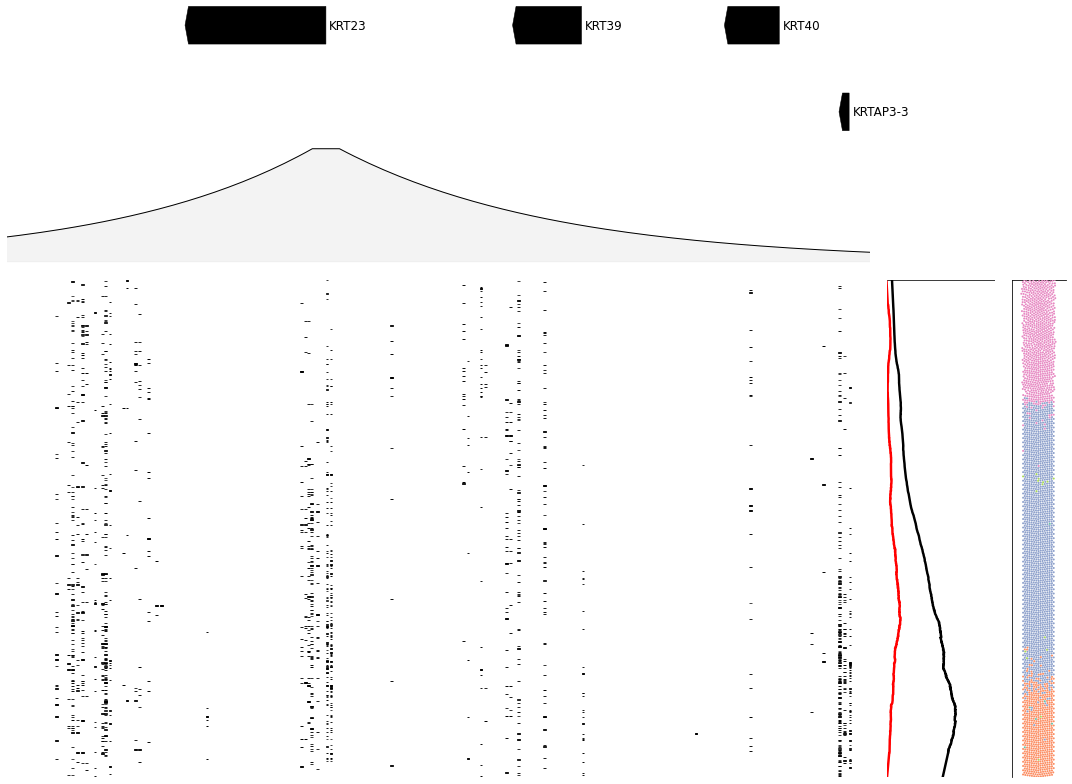

In [35]:
make_fragment_plot('KRT23', 'Cortex', 0.2e5, 0.6e5, 0.5, enforce_max=(0.8, 0.0005))
plt.savefig(os.path.join(RESULTS, 'suppfigs','KRT_cortex.png'))

Plotting fragments:   0%|          | 0/1583 [00:00<?, ?it/s]

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
Intersecting RP models with interval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 359.96it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
Trying to set attribute `.obs` of view, copying.


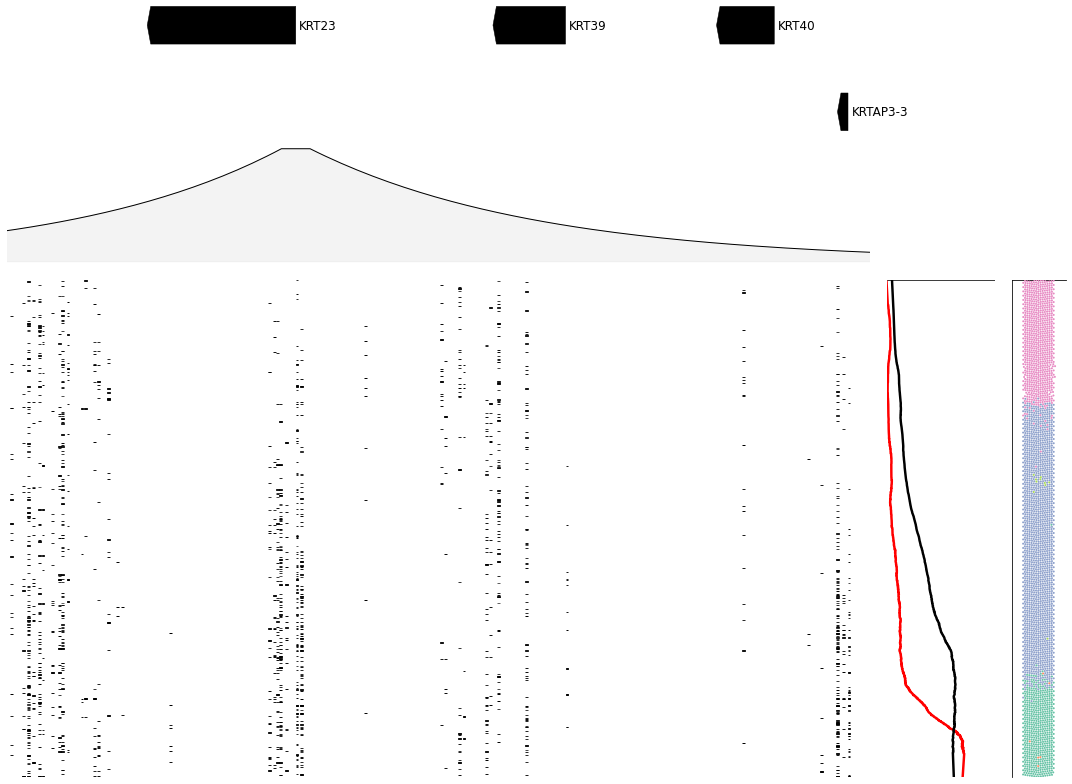

In [36]:
fig = make_fragment_plot('KRT23', 'Medulla', 0.15e5, 0.6e5, 0.5,enforce_max=(0.8, 0.0005))
#fig.axes[-2].lines.pop(0)
plt.savefig(os.path.join(RESULTS, 'suppfigs','KRT_medulla.png'))

Plotting fragments:   0%|          | 0/5357 [00:00<?, ?it/s]

/Users/alynch/opt/miniconda3/envs/mirarep/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
Intersecting RP models with interval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 339.02it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
Trying to set attribute `.obs` of view, copying.


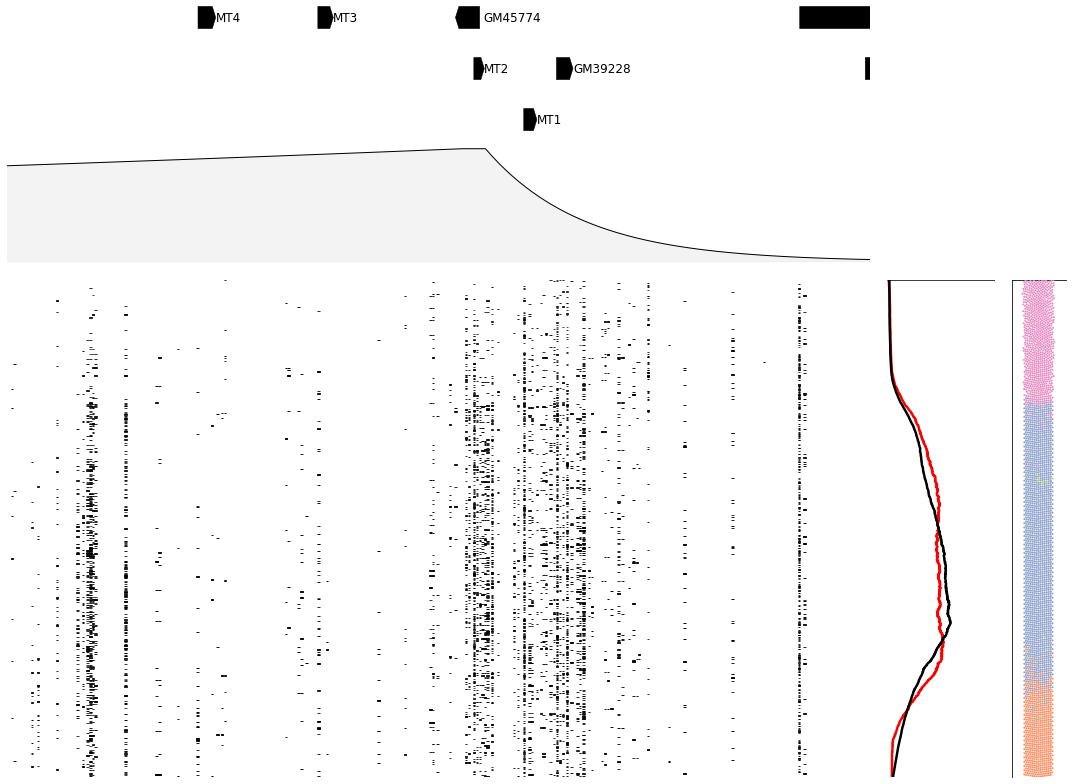

In [37]:
fig = make_fragment_plot('MT2','Cortex', 0.6e5, 0.5e5, 0.5, (2.3, 0.0035))
#make_fragment_plot('WNT3','Cortex', 0.5e5, 0.6e5, 0.5)
#fig.axes[-2].lines.pop(0)
plt.savefig(os.path.join(RESULTS, 'suppfigs','MT2_fragment_plot.png'))

Plotting fragments:   0%|          | 0/5518 [00:00<?, ?it/s]

Intersecting RP models with interval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 475.92it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
Trying to set attribute `.obs` of view, copying.


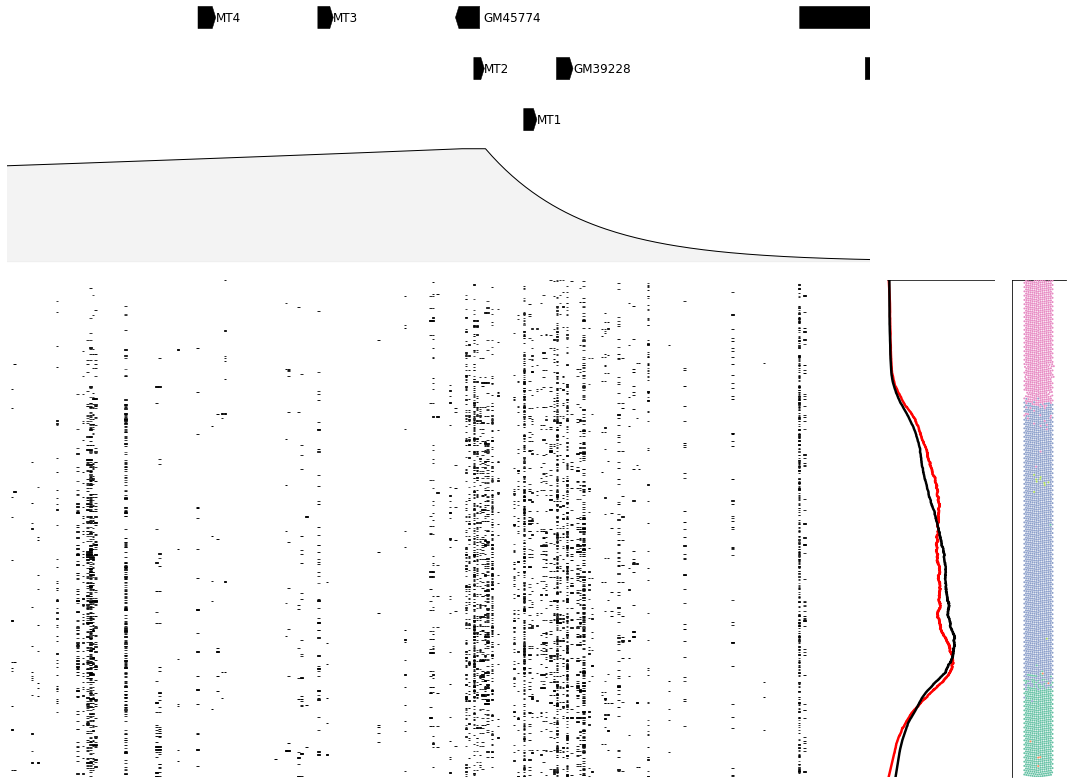

In [38]:
fig = make_fragment_plot('MT2','Medulla', 0.6e5, 0.5e5, 0.5, (2.3, 0.0035))
#make_fragment_plot('WNT3','Cortex', 0.5e5, 0.6e5, 0.5)
#fig.axes[-2].lines.pop(0)
plt.savefig(os.path.join(RESULTS, 'suppfigs','MT2_fragment_plot_medulla.png'))

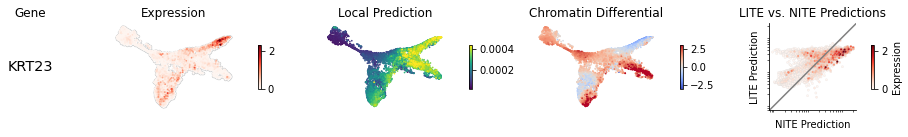

In [34]:
mira.pl.plot_chromatin_differential(hair_follicle, genes = 'KRT23', height = 2, aspect = 1.5, trim_lite_prediction=2,
                                   size = 0.5, counts_layer = 'smoothed', basis = 'horizontal_umap')
plt.show()

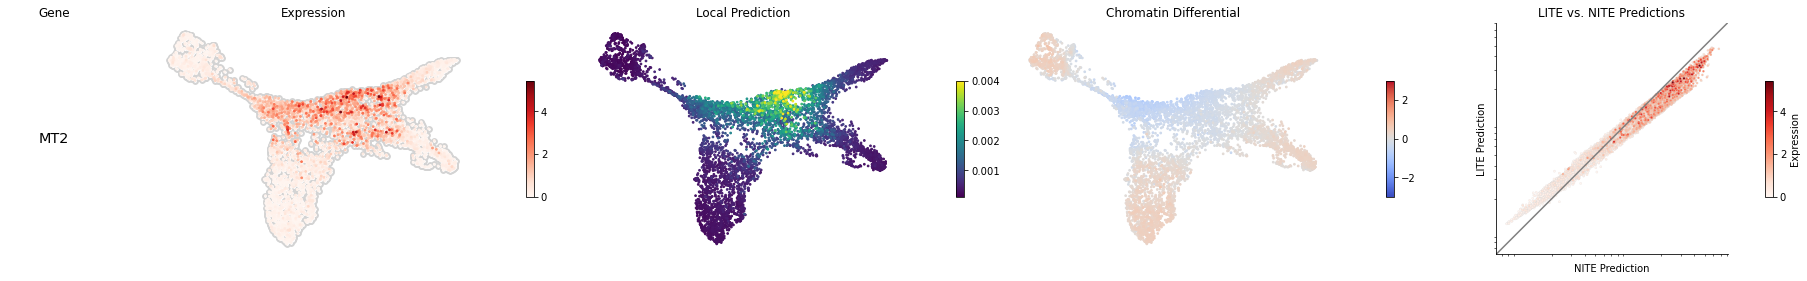

In [35]:
mira.pl.plot_chromatin_differential(hair_follicle, genes = ['MT2'], size = 3, height=4, trim_lite_prediction=4,
                                    basis = 'horizontal_umap', counts_layer = 'smoothed')
plt.savefig(os.path.join(RESULTS, 'suppfigs','MT2_chromdiff_plot.png'))

Plotting fragments:   0%|          | 0/1044 [00:00<?, ?it/s]

Intersecting RP models with interval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 155.90it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
Trying to set attribute `.obs` of view, copying.


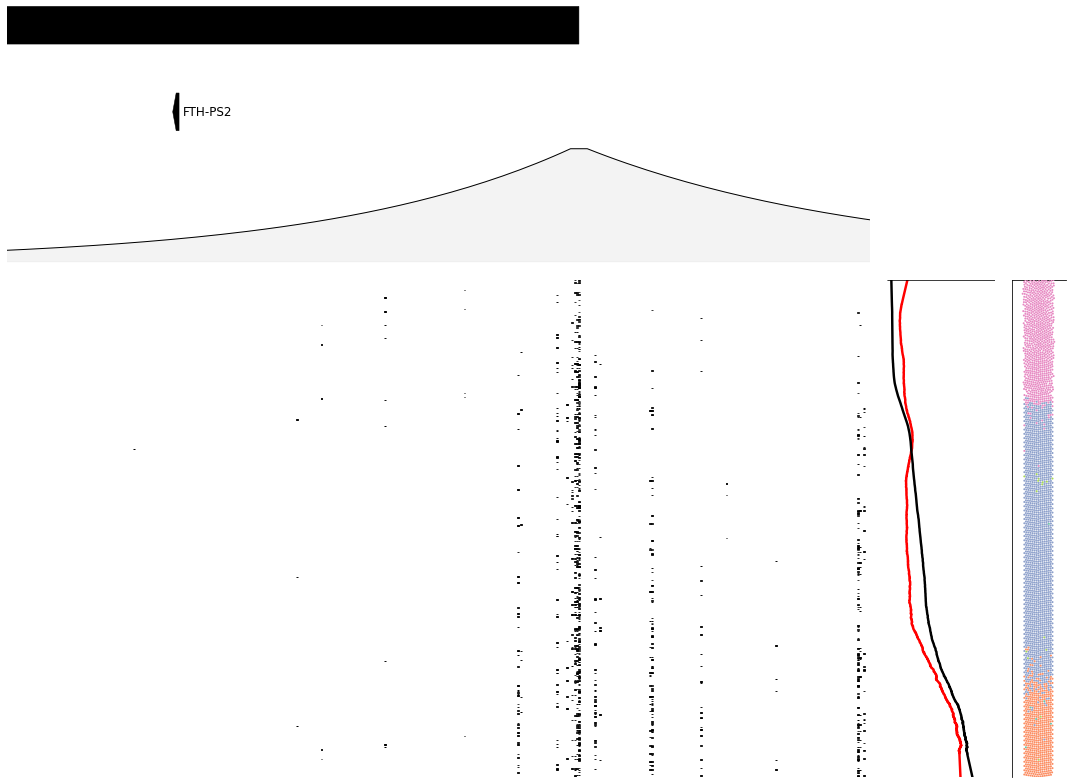

In [41]:
fig = make_fragment_plot('BRAF','Cortex', -2e4, 0.52e5, 0.5, (4, 0.005))
#make_fragment_plot('WNT3','Cortex', 0.5e5, 0.6e5, 0.5)
#fig.axes[-2].lines.pop(0)
plt.savefig(os.path.join(RESULTS, 'suppfigs','BRAF_fragment_plot_cortex.extended.png'))

Plotting fragments:   0%|          | 0/962 [00:00<?, ?it/s]

Intersecting RP models with interval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 327.12it/s]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
Trying to set attribute `.obs` of view, copying.


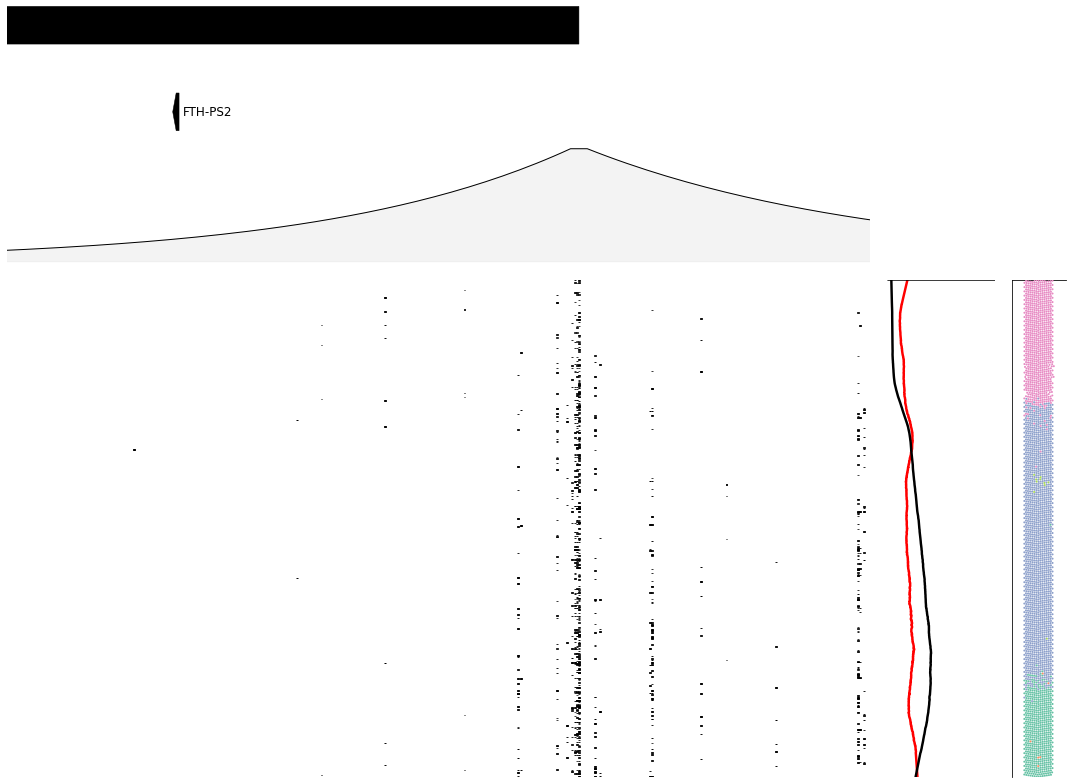

In [44]:
fig = make_fragment_plot('BRAF','Medulla', -2e4, 0.52e5, 0.5, (4, 0.005))
#make_fragment_plot('WNT3','Cortex', 0.5e5, 0.6e5, 0.5)
#fig.axes[-2].lines.pop(0)
plt.savefig(os.path.join(RESULTS, 'suppfigs','BRAF_fragment_plot_medulla.extended.png'))